In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.transforms.v2 as v2

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import random
from tqdm import tqdm
import sys

sys.path.append('./src')
from src.data import MultiSet, ImageTransforms, ProfileTransform, PairAugmentation
from src.profile_encoder import ProfileTransformer
from src.image_encoder import ImageEncoder
from src.model import MultiModel
from src.coordination import DistanceLoss, CLIPLoss, RankLoss

from lightning import Trainer

# from torch.utils.tensorboard import SummaryWriter
# from accelerate import Accelerator
# from accelerate.utils import GradientAccumulationPlugin

import scienceplots
plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

# %matplotlib widget

import timm

In [2]:
encoder = ProfileTransformer(7, 256, 2)

In [3]:
annotation_id = 'small'
max_len = 256

data_path = Path('./data/CytoSense')

image_transforms = ImageTransforms()
signal_transforms = ProfileTransform(max_len=max_len)
pair_augmentation = PairAugmentation()

train_set = MultiSet(annotation_path=data_path / f'{annotation_id}_train.csv', 
                   image_transforms=image_transforms,
                   profile_transform=signal_transforms,
                   pair_augmentation=pair_augmentation)

test_set = MultiSet(annotation_path=data_path / f'{annotation_id}_test.csv', 
                    image_transforms=image_transforms,
                    profile_transform=signal_transforms,
                    pair_augmentation=None)

valid_set = MultiSet(annotation_path=data_path / f'{annotation_id}_valid.csv', 
                    image_transforms=image_transforms,
                    profile_transform=signal_transforms,
                    pair_augmentation=None)


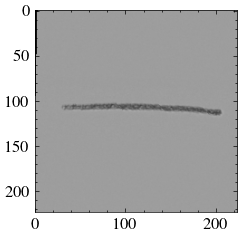

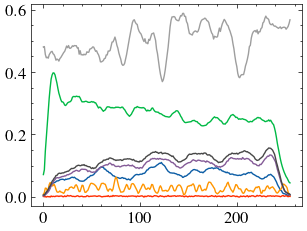

{'image': tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.6145, 0.6153, 0.6207],
          [0.0000, 0.0000, 0.0000,  ..., 0.6134, 0.6142, 0.6141],
          [0.0000, 0.0000, 0.0000,  ..., 0.6206, 0.6167, 0.6150],
          ...,
          [0.6161, 0.6166, 0.6169,  ..., 0.6227, 0.6167, 0.6168],
          [0.6157, 0.6181, 0.6203,  ..., 0.6197, 0.6176, 0.6180],
          [0.6179, 0.6127, 0.6222,  ..., 0.6197, 0.6156, 0.6202]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6145, 0.6153, 0.6207],
          [0.0000, 0.0000, 0.0000,  ..., 0.6134, 0.6142, 0.6141],
          [0.0000, 0.0000, 0.0000,  ..., 0.6206, 0.6167, 0.6150],
          ...,
          [0.6161, 0.6166, 0.6169,  ..., 0.6227, 0.6167, 0.6168],
          [0.6157, 0.6181, 0.6203,  ..., 0.6197, 0.6176, 0.6180],
          [0.6179, 0.6127, 0.6222,  ..., 0.6197, 0.6156, 0.6202]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6145, 0.6153, 0.6207],
          [0.0000, 0.0000, 0.0000,  ..., 0.6134, 0.6142, 0.6141],
          [0.0000, 0.0000, 0.00

In [10]:
data = train_set[0]

plt.imshow(data['image'].permute(1, 2, 0))
plt.show()

plt.plot(data['profile'])
plt.show()

data

In [11]:
noise = np.random.normal(loc=color_mode, scale=color_std, size=image.shape).astype(np.uint8)

plt.imshow(noise)

NameError: name 'color_mode' is not defined

In [ ]:
image = cv2.imread(train_set.image_files[20], cv2.IMREAD_GRAYSCALE)
color_mode, color_std = find_background_stats(image, p=3, closest=0.90)


def cover_scale(image, bg, std) -> np.ndarray:
    noise = np.random.normal(loc=bg, scale=std, size=image[:25].shape).astype(image.dtype)
    image[:25] = noise
    return image


def pad_image_to_square(image, bg, std) -> np.ndarray:

    height, width = image.shape[:2]
    
    # Calculate new size and padding
    max_side = max(height, width)
    y_from = (max_side - height) // 2
    x_from = (max_side - width) // 2

    if x_from > 0 or y_from > 0:
        # Create a new image with padding
        new_image = np.full((max_side, max_side), fill_value=bg, dtype=image.dtype)
        noise = np.random.normal(loc=0, scale=std, size=new_image.shape).astype(image.dtype)
        output_img = np.clip(new_image + noise, 0, 255).astype(image.dtype)
        # Place the original image in the center
        output_img[y_from:y_from+height, x_from:x_from+width] = image
    else:
        output_img = image
        
    return output_img

fig, ax = plt.subplots()

image = cover_scale(image, color_mode, color_std)
image = pad_image_to_square(image, color_mode, color_std)
ax.imshow(image, cmap='gray')
        
fig.set_size_inches(10, 10)

NameError: name 'cv2' is not defined

In [ ]:
import yaml

with open('model_cards/example.yaml', 'r') as stream:
    foo = yaml.safe_load(stream)


foo

{'dataset': 'small',
 'dim_embedding': 512,
 'max_len': 256,
 'bs': 32,
 'patience': 8,
 'image_encoder_args': {'name': 'efficientnet_b0',
  'pretrained': False,
  'num_classes': 0},
 'profile_encoder_args': {'dim_in': 7,
  'dim_out': 128,
  'num_head': 4,
  'num_layers': 6,
  'dim_feedforward': 1024,
  'dropout': 0.1,
  'activation': 'gelu',
  'max_len': 256},
 'classifier_args': {'dim_hidden_layers': [1024],
  'activation': 'gelu',
  'dropout': 0.1},
 'coordination_args': {'method': 'clip', 'supervised': True, 'alpha': 0.5},
 'optim_args': {'lr': 0.0001, 'weight_decay': 1e-12},
 'trainer_args': {'precision': '16-mixed',
  'min_epochs': 50,
  'max_epochs': 200,
  'accumulate_grad_batches': 4}}

In [4]:
dim_embedding = 256

image_encoder_args = {
    'name': 'efficientnet_b0',
    'pretrained': False,
    'num_classes': 0,
}

profile_encoder_args = {
    'dim_in': 7,
    'num_head': 2,
    'num_layers': 6, 
    'dim_feedforward': 2024, 
    'dropout': 0.1, 
    'activation': 'gelu',
    'max_len': max_len,
}

classifier_args = {
    'dim_hidden_layers': (1024,),
    'activation': 'gelu',
    'dropout': 0.1,
}

coordination_args = {
    'method': 'clip',  # distance, clip, or rank
    # 'margin': 5,
    'alpha': 0.5,
    'supervised': True
}

optim_args = {}

model = MultiModel(
    image_encoder_args=image_encoder_args,
    profile_encoder_args=profile_encoder_args,
    classifier_args=classifier_args,
    coordination_args=coordination_args,
    dim_embed=dim_embedding,
    class_names=train_set.class_names,
    optim_args=optim_args
)

model

MultiModel(
  (image_encoder): ImageEncoder(
    (backbone): EfficientNet(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), strid

In [ ]:
foo = v2.RandomAffine((-5, 5))
foo.fill = 5

print(foo)

RandomAffine(degrees=[-5.0, 5.0], interpolation=InterpolationMode.NEAREST, fill=5)


In [5]:
bs = 16

def multi_collate(batch, model=model):

    image, profile, label, image_shape, profile_len = zip(*(sample.values() for sample in batch))

    image = {'image': torch.stack(image)}
    profile = model.profile_encoder.tokenize(profile)
    label = {'label': model.name_to_id(label)}
    image_shape = {'image_shape': torch.stack(image_shape)}
    profile_len = {'profile_len': torch.stack(profile_len)}

    return image | profile | label | profile_len | image_shape

train_loader = DataLoader(dataset=train_set, batch_size=bs, 
                        shuffle=True, num_workers=8, 
                        drop_last=True, collate_fn=multi_collate)

test_loader = DataLoader(dataset=test_set, batch_size=bs, 
                         num_workers=8, collate_fn=multi_collate)

valid_loader = DataLoader(dataset=valid_set, batch_size=bs, 
                         num_workers=8, drop_last=True, 
                         collate_fn=multi_collate)

In [6]:
batch = next(iter(train_loader))

encoder(**batch).shape

torch.Size([16, 9])

In [ ]:
pad = nn.ZeroPad2d((0, 1, 0, 0))
pad(batch['profile'])[0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0106, 0.1572, 0.0330,  ..., 0.0088, 0.3877, 0.0000],
        [0.0167, 0.2285, 0.0292,  ..., 0.0097, 0.4204, 0.0000],
        ...,
        [0.0173, 0.1105, 0.0123,  ..., 0.0176, 0.5042, 0.0000],
        [0.0107, 0.0805, 0.0190,  ..., 0.0082, 0.5087, 0.0000],
        [0.0096, 0.0669, 0.0305,  ..., 0.0086, 0.4983, 0.0000]])

In [ ]:
trainer = Trainer()
trainer.fit(model, train_loader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/veikka/miniconda3/envs/dippa/lib/python3.12/site-packages/lightning/pytorch/loops/utilities.py:73: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
/home/veikka/miniconda3/envs/dippa/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch

Training: |          | 0/? [00:00<?, ?it/s]

TypeError: cat(): argument 'tensors' (position 1) must be tuple of Tensors, not dict_values

In [ ]:
label = batch['label']

label

tensor([2, 0, 0, 0, 2, 0, 1, 4, 1, 1, 4, 4, 3, 1, 4, 4])

(np.int64(1144), tensor(0.5426))

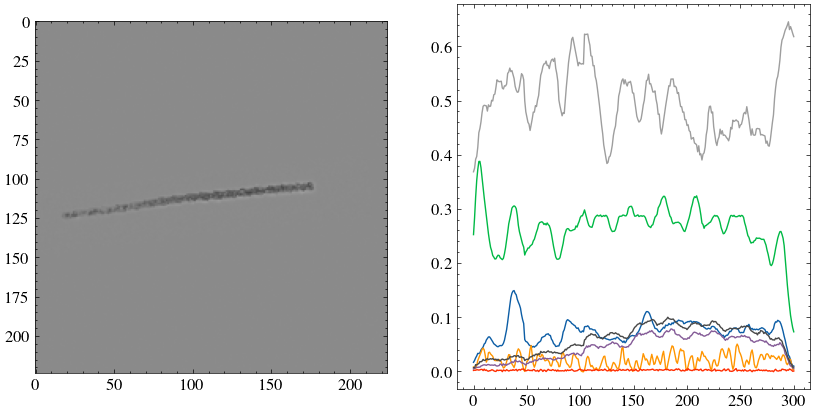

In [ ]:
ix = 1

image, signal, y = train_set[ix].values()

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image.permute(1, 2, 0))
ax[1].plot(signal)

fig.set_size_inches(10, 5)

train_set.X[ix], (image).mean()

## Cross-Modality Training

In [ ]:
torch.cuda.empty_cache()

In [ ]:
lstm = nn.LSTM(5, 16, num_layers=3, batch_first=True)
lstm.eval()

x1 = torch.randn(5, 10, 5)
x2 = F.pad(x1, (0, 0, 0, 10))

with torch.no_grad():
    y1, _ = lstm(x1)
    y2, _ = lstm(x2)

i = torch.tensor([1, 2, 3, 4, 5]).long()

y1[np.arange(5), i].shape

torch.Size([5, 16])

In [ ]:
dim_space = 256

signal_encoder = TS_Transformer(dim_model=7, num_head=1, num_layers=12,
                         dim_feedforward=1024, max_len=256)

image_encoder = ImageEncoder('resnet18')

model = BiModal(image_encoder, signal_encoder, dim_space)

classifier = nn.Sequential(
    nn.Linear(dim_space, 4096),
    nn.GELU(),
    nn.Linear(4096, 4096),
    nn.GELU(),
    nn.Linear(4096, annotation_id)
)

crossmodal_criterion = RankLoss(margin=2.5)
classification_criterion = nn.CrossEntropyLoss()

parameters = list(model.parameters()) \
    + list(crossmodal_criterion.parameters()) \
    + list(classifier.parameters())
optimizer = optim.Adam(parameters, lr=1e-4, weight_decay=1e-10)

plugin = GradientAccumulationPlugin(num_steps=4, 
                                    sync_with_dataloader=False)
accelerator = Accelerator(mixed_precision='fp16', 
                          gradient_accumulation_plugin=plugin)

writer = SummaryWriter()

model, classifier = accelerator.prepare(model, classifier)
crossmodal_criterion, classification_criterion = accelerator.prepare(
    crossmodal_criterion, classification_criterion
)
optimizer = accelerator.prepare(optimizer)
train_loader, test_loader, valid_loader = accelerator.prepare(
    train_loader, test_loader, valid_loader
)

print(sum(torch.numel(p) for p in model.parameters()))

/home/veikka/miniconda3/envs/dippa/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


11499627


In [ ]:
def step(model, classifier, batch, crossmodal_criterion, 
         classification_criterion, alpha):
    image, signal, y = batch

    out = model(image, signal)
    loss = alpha * crossmodal_criterion(*out)

    x = torch.cat(out, 0)
    y = torch.tile(y, (2,))
    out = classifier(x)
    loss += (1 - alpha) * classification_criterion(out, y)
    
    return loss


def set_train(*modules):
    for module in modules:
        module.train()


def set_eval(*modules):
    for module in modules:
        module.eval()


@torch.no_grad()
def validate(model, classifier, crossmodal_criterion, 
             classification_criterion, dataloader, alpha):
    set_eval(model, classifier, crossmodal_criterion)
    loss = 0
    for batch in dataloader:
        loss += step(model, classifier, batch, crossmodal_criterion,
                     classification_criterion, alpha).detach().item()
    return loss / len(dataloader)


In [ ]:
epochs = 50
steps = len(train_loader) * epochs
iterator = tqdm(range(1, steps + 1))

generator = iter(train_loader)

accum_steps = accelerator.gradient_accumulation_steps
accumulated_loss = 0

alpha = .5

set_train(model, classifier, crossmodal_criterion)

for i in iterator:

    try:
        batch = next(generator)
    except StopIteration:
        generator = iter(train_loader)
        batch = next(generator)

    with accelerator.accumulate(model, classifier, crossmodal_criterion):
        optimizer.zero_grad()
        loss = step(model, classifier, batch, crossmodal_criterion,
                    classification_criterion, alpha)
        accelerator.backward(loss)
        optimizer.step()
        accumulated_loss += loss.detach().item()

    if i % accum_steps == 0:
        accumulated_loss /= accum_steps
        valid_loss = validate(model, classifier, crossmodal_criterion,
                              classification_criterion, valid_loader, alpha)
        writer.add_scalar('Loss/train:', accumulated_loss, i // accum_steps)
        writer.add_scalar('Loss/validation:', valid_loss, i // accum_steps)
        accumulated_loss = 0
        set_train(model, classifier, crossmodal_criterion)


  0%|          | 0/500 [00:00<?, ?it/s]

  1%|▏         | 7/500 [01:30<1:45:59, 12.90s/it]


KeyboardInterrupt: 

In [ ]:
signal_encoder.position.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3385,  1.3989,  0.5031,  ..., -0.2661,  0.2233,  0.0210],
        [-0.3543,  0.1436, -1.2910,  ..., -2.4231, -2.2016,  0.2698],
        ...,
        [ 1.0672, -0.8952,  1.0316,  ..., -1.2471,  1.0585, -1.6894],
        [ 1.3205, -1.0552,  0.1864,  ...,  1.9254,  0.0748, -1.2294],
        [ 1.8637,  0.5610,  0.2012,  ..., -1.6152,  0.3091,  1.0244]],
       requires_grad=True)

## Testing the classifier

In [ ]:
set_eval(model, classifier)

I = []
S = []
label = []
pred = []

for image, signal, y in tqdm(test_loader):
    with torch.no_grad():
        encoding_1, encoding_2 = model(image, signal)
        I.append(encoding_1)
        S.append(encoding_2)
        pred.append((classifier(encoding_1) + classifier(encoding_2)))
        label.append(y)

I = torch.cat(I)
S = torch.cat(S)
pred = torch.cat(pred).cpu()
label = torch.cat(label).cpu()

100%|██████████| 215/215 [00:07<00:00, 28.92it/s]


In [ ]:
I_np = I.cpu().numpy()
S_np = S.cpu().numpy()
E = np.concat((I_np, S_np), 0)
label_np = label.numpy()
label_E = np.tile(label_np, (2,))

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

reduced = TSNE(2, perplexity=20, early_exaggeration=20).fit_transform(E)
# reduced = PCA(2).fit_transform(E)

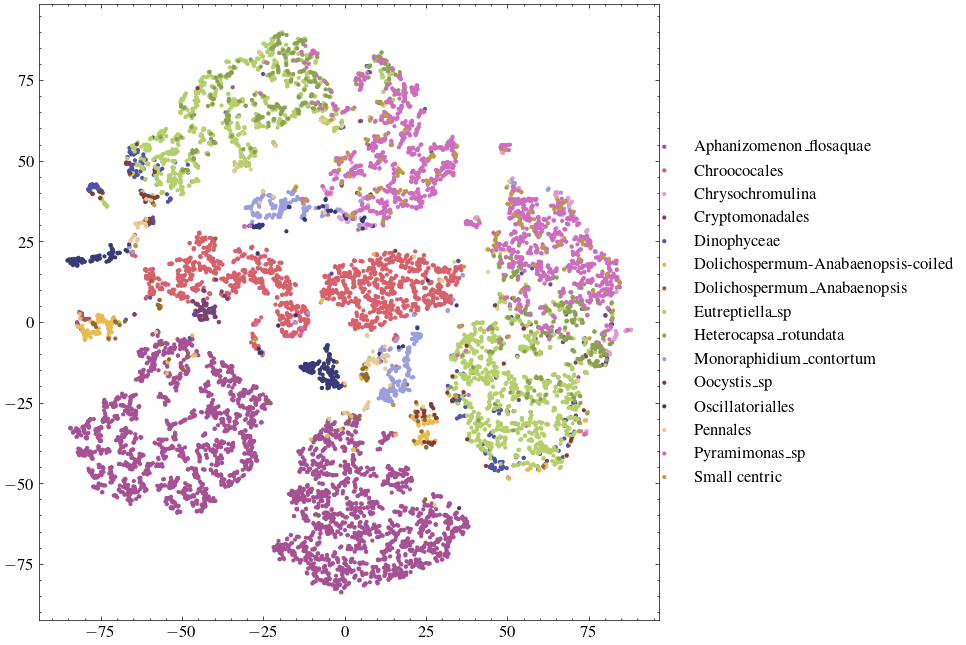

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()#projection='3d')

palette = plt.colormaps.get_cmap('tab20b')
colors = random.sample(palette.colors, annotation_id)

for y, c in zip(np.unique(label_E), colors):
    class_name = test_set.label_encoder.inverse_transform([y])[0]
    e = reduced[label_E == y]
    ax.scatter(*zip(*e), label=class_name, s=4, c=[c]*len(e))

fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()

/home/veikka/miniconda3/envs/dippa/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:2036: UndefinedMetricWarning: 'k' (15) greater than or equal to 'n_classes' (15) will result in a perfect score and is therefore meaningless.
  warnings.warn(


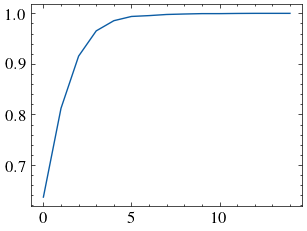

In [ ]:
from sklearn.metrics import top_k_accuracy_score

pred_np = pred.numpy()

plt.plot([top_k_accuracy_score(label_np, pred_np, k=k) for k in range(1, annotation_id+1)])

In [ ]:
from sklearn.metrics import classification_report

pred_class = pred.argmax(1)

names = test_set.label_encoder.inverse_transform(list(range(annotation_id)))
pd.DataFrame(classification_report(label, pred_class, target_names=names, output_dict=True)).T

,precision,recall,f1-score,support
Aphanizomenon_flosaquae,0.999265,0.845245,0.915825,1609.000000
Chroococales,0.837433,0.998724,0.910995,784.000000
Chrysochromulina,0.300699,0.895833,0.450262,96.000000
Cryptomonadales,0.955882,0.902778,0.928571,72.000000
Dinophyceae,0.567742,0.520710,0.543210,169.000000
Dolichospermum-Anabaenopsis-coiled,0.801653,0.915094,0.854626,106.000000
Dolichospermum_Anabaenopsis,0.101695,0.428571,0.164384,28.000000
Eutreptiella_sp,0.930041,0.467909,0.622590,966.000000
Heterocapsa_rotundata,0.271394,0.397849,0.322674,279.000000
Monoraphidium_contortum,0.972477,0.522167,0.679487,203.000000


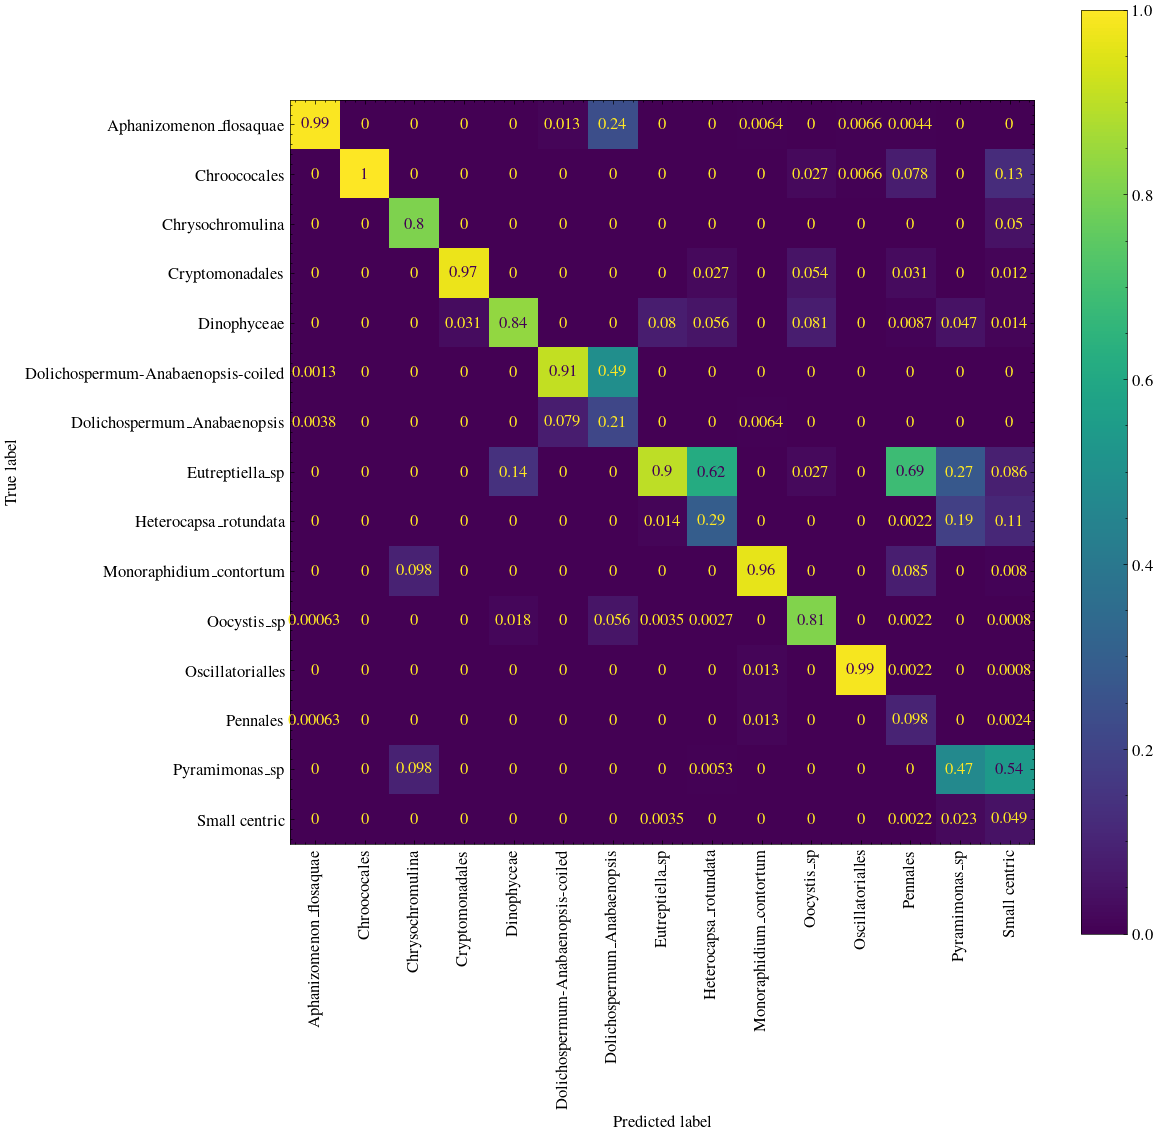

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots()
cm = confusion_matrix(label, pred_class, normalize='pred')
ConfusionMatrixDisplay(cm, display_labels=names).plot(xticks_rotation=90, ax=ax)
fig.set_size_inches(12, 12)

